In [24]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display

#image
from skimage.transform import resize
from skimage.util import crop
import random
import numpy as np

#keras
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Activation, Add, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Conv2D, ReLU, LeakyReLU, Conv2DTranspose, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

#pip install -q -U tensorboard

In [25]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [72]:
#Hyperparameters
PATH = "./X-Ray_Disease_Classification-master/Data/Images/"
effusion_path = "./X-Ray_Disease_Classification-master/Data/test2.csv"
infiltration_path = "./X-Ray_Disease_Classification-master/Data/test4.csv"

BUFFER_SIZE = 400
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

N_CLASSES = 2
CLASS_NAMES = [ 'Effusion', 'Infiltration']

# n_input = 200704
n_input = 25088

OUTPUT_CHANNELS = 2
EPOCHS =150

In [27]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_png(image, channels=3)
    
    input_image = tf.cast(image, tf.float32)
    input_image = input_image / 255.
    
    return input_image

(1024, 1024, 3)


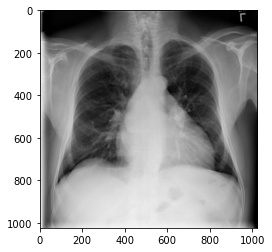

In [28]:
#test_load_image
inp= load(PATH+'00000001_000.png')
# casting to int for matplotlib to show the image
print(inp.shape)
plt.figure()
plt.imshow(inp)

In [29]:
#Preprocessing
def resize(input_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return input_image

def random_crop(input_image):

    cropped_image = tf.image.random_crop(input_image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image

def normalize(input_image):
    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std = np.array([0.229, 0.224, 0.225])
    input_image = (input_image - imagenet_mean) / imagenet_std
    return input_image


@tf.function()
def random_jitter(input_image):
    input_image = resize(input_image, 254, 254) # resizing to 286 x 286 x 3

    input_image = random_crop(input_image) # randomly cropping to 256 x 256 x 3

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)

    return input_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


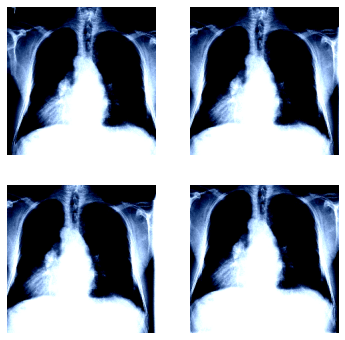

In [30]:
#test_jitter
"""
1. Resize an image to bigger height and width
2. Randomly crop to the target size
3. Randomly flip the image horizontally
"""

plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp = random_jitter(inp)
    rj_inp = normalize(rj_inp)
    out2 = rj_inp
    plt.subplot(2, 2, i+1)
    plt.imshow(out2)
    plt.axis('off')
plt.show()

In [31]:
def load_image_train(image_file):
    input_image = load(PATH+image_file)
    input_image = random_jitter(input_image)
    input_image = normalize(input_image)

    return input_image

def load_image_test(image_file):
    input_image = load(PATH+image_file)
    input_image = resize(input_image, IMG_HEIGHT, IMG_WIDTH)
    input_image = normalize(input_image)

    return input_image

In [73]:
def load_csv_train(image, label):
    input_image = load_image_train(image)

    return input_image, label

def load_csv_test(image, label):
    input_image = load_image_test(image)

    return input_image, label

#Input Pipeline
import pandas as pd
import numpy

num_lines_eff = sum(1 for l in open(effusion_path))
num_lines_inf = sum(1 for l in open(infiltration_path))
print(num_lines_eff)
print(num_lines_inf)

size_train = 3000
size_test = 100
skip_idx_train_eff = random.sample(range(1, num_lines_eff), num_lines_eff - size_train)
skip_idx_test_eff = random.sample(range(1, num_lines_eff), num_lines_eff - size_test)
skip_idx_train_inf = random.sample(range(1, num_lines_inf), num_lines_inf - size_train)
skip_idx_test_inf = random.sample(range(1, num_lines_inf), num_lines_inf - size_test)

eff_train = pd.read_csv(effusion_path, skiprows=skip_idx_train_eff, index_col=None, header = 0)
eff_test = pd.read_csv(effusion_path, skiprows=skip_idx_test_eff, index_col=None, header = 0)
inf_train = pd.read_csv(infiltration_path,  skiprows=skip_idx_train_inf, index_col=None, header = 0)
inf_test = pd.read_csv(infiltration_path,  skiprows=skip_idx_test_inf, index_col=None, header = 0)

train = []
train.append(eff_train)
train.append(inf_train)
train = pd.concat(train, axis=0, ignore_index=True)
from sklearn.utils import shuffle
train = shuffle(train)
image_train = train.pop('Image Index')
label_train = train.pop('Finding Labels')
print(image_train)
print(label_train)

train_dataset = tf.data.Dataset.from_tensor_slices((image_train, label_train))
train_dataset = train_dataset.map(load_csv_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

test = []
test.append(eff_test)
test.append(inf_test)
test = pd.concat(test, axis=0, ignore_index=True)
from sklearn.utils import shuffle
test = shuffle(test)
image_test = test.pop('Image Index')
label_test = test.pop('Finding Labels')
print(image_test)
print(label_test)

test_dataset = tf.data.Dataset.from_tensor_slices((image_test, label_test))
test_dataset = test_dataset.map(load_csv_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

3956
9548
5204    00021801_000.png
1575    00014253_049.png
5832    00028777_001.png
4410    00015895_012.png
398     00004418_011.png
              ...       
1235    00011967_003.png
2243    00020702_005.png
2733    00027415_066.png
141     00001558_007.png
5908    00029786_000.png
Name: Image Index, Length: 5998, dtype: object
5204    1
1575    0
5832    1
4410    1
398     0
       ..
1235    0
2243    0
2733    0
141     0
5908    1
Name: Finding Labels, Length: 5998, dtype: int64
149    00018507_009.png
88     00027623_009.png
37     00011402_009.png
22     00008910_000.png
176    00025721_000.png
             ...       
163    00021862_003.png
12     00005773_010.png
6      00003523_026.png
119    00006586_004.png
51     00013243_004.png
Name: Image Index, Length: 198, dtype: object
149    1
88     0
37     0
22     0
176    1
      ..
163    1
12     0
6      0
119    1
51     0
Name: Finding Labels, Length: 198, dtype: int64


In [33]:
#Build Model
def CNN_MODEL():
    inputs = Input(shape=[IMG_HEIGHT, IMG_WIDTH,3])
    
    x= inputs
    
    initializer = tf.random_normal_initializer(0., 0.02)

    model = Sequential()
    model.add(Conv2D(64, 4, strides=2, padding='valid', kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, 4, strides=2, padding='valid',
                                 kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(256, 4, strides=2, padding='valid',
                                 kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation="sigmoid"))
    
    x=model(x)
    
    return Model(inputs=inputs, outputs = x)

In [34]:
CNN = CNN_MODEL()
CNN.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 931329    
Total params: 931,329
Trainable params: 930,433
Non-trainable params: 896
_________________________________________________________________


In [76]:
with tf.device('/GPU:0'):
    optimizer = Adam(lr=0.001)
    
    CNN.compile(optimizer=optimizer,
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

    history = CNN.fit(train_dataset, epochs=EPOCHS, 
                    validation_data=(test_dataset))


Epoch 1/150
188/188 [==============================] - 43s 229ms/step - loss: 0.2106 - accuracy: 0.6579 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/150
188/188 [==============================] - 42s 226ms/step - loss: 0.2063 - accuracy: 0.6774 - val_loss: 0.2097 - val_accuracy: 0.6970
Epoch 3/150
188/188 [==============================] - 42s 222ms/step - loss: 0.2036 - accuracy: 0.6721 - val_loss: 0.2024 - val_accuracy: 0.6869
Epoch 4/150
188/188 [==============================] - 41s 221ms/step - loss: 0.2042 - accuracy: 0.6799 - val_loss: 0.1993 - val_accuracy: 0.7475
Epoch 5/150
188/188 [==============================] - 41s 221ms/step - loss: 0.2016 - accuracy: 0.6872 - val_loss: 0.1954 - val_accuracy: 0.7374
Epoch 6/150
188/188 [==============================] - 41s 216ms/step - loss: 0.1977 - accuracy: 0.6919 - val_loss: 0.1912 - val_accuracy: 0.7172
Epoch 7/150
188/188 [==============================] - 41s 219ms/step - loss: 0.1975 - accuracy: 0.6936 - val_loss: 

Epoch 57/150
188/188 [==============================] - 40s 214ms/step - loss: 0.1493 - accuracy: 0.7908 - val_loss: 0.1821 - val_accuracy: 0.7525
Epoch 58/150
188/188 [==============================] - 40s 214ms/step - loss: 0.1513 - accuracy: 0.7826 - val_loss: 0.1950 - val_accuracy: 0.7374
Epoch 59/150
188/188 [==============================] - 40s 214ms/step - loss: 0.1493 - accuracy: 0.7811 - val_loss: 0.1894 - val_accuracy: 0.7374
Epoch 60/150
188/188 [==============================] - 40s 214ms/step - loss: 0.1523 - accuracy: 0.7783 - val_loss: 0.1843 - val_accuracy: 0.7525
Epoch 61/150
188/188 [==============================] - 40s 214ms/step - loss: 0.1488 - accuracy: 0.7889 - val_loss: 0.1719 - val_accuracy: 0.7525
Epoch 62/150
188/188 [==============================] - 41s 216ms/step - loss: 0.1519 - accuracy: 0.7809 - val_loss: 0.1959 - val_accuracy: 0.7323
Epoch 63/150
188/188 [==============================] - 41s 217ms/step - loss: 0.1492 - accuracy: 0.7849 - val_loss: 0

188/188 [==============================] - 41s 215ms/step - loss: 0.1209 - accuracy: 0.8348 - val_loss: 0.1863 - val_accuracy: 0.7626
Epoch 113/150
188/188 [==============================] - 35s 187ms/step - loss: 0.1198 - accuracy: 0.8316 - val_loss: 0.1592 - val_accuracy: 0.7879
Epoch 114/150
188/188 [==============================] - 35s 185ms/step - loss: 0.1176 - accuracy: 0.8364 - val_loss: 0.2321 - val_accuracy: 0.7172
Epoch 115/150
188/188 [==============================] - 35s 186ms/step - loss: 0.1211 - accuracy: 0.8343 - val_loss: 0.1661 - val_accuracy: 0.7626
Epoch 116/150
188/188 [==============================] - 35s 185ms/step - loss: 0.1135 - accuracy: 0.8463 - val_loss: 0.1518 - val_accuracy: 0.7980
Epoch 117/150
188/188 [==============================] - 34s 180ms/step - loss: 0.1192 - accuracy: 0.8373 - val_loss: 0.1810 - val_accuracy: 0.7727
Epoch 118/150
188/188 [==============================] - 35s 185ms/step - loss: 0.1161 - accuracy: 0.8431 - val_loss: 0.1881 -

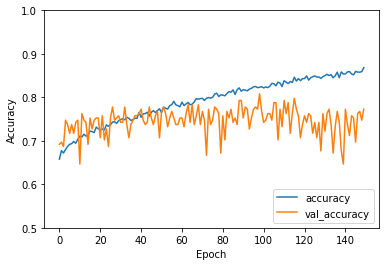

In [77]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [78]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "./CNN_Training_Models/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

CNN.save_weights(checkpoint_path.format(epoch=150))
latest = tf.train.latest_checkpoint(checkpoint_dir)

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=10)

# Create a new model instance
model = CNN_MODEL()

model.load_weights(latest)

model.save_weights(checkpoint_path.format(epoch=0))

model.compile(optimizer=optimizer,
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=['accuracy'])

model.fit(train_dataset,
          epochs=100, 
          callbacks=[cp_callback],
          validation_data=(test_dataset),
          verbose=0)

In [11]:
import keras

def DenseNet_MODEL():
    img_input = Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    
    base_model = tf.keras.applications.densenet.DenseNet121(
        include_top=False,
        input_tensor=img_input,
        input_shape=[IMG_HEIGHT, IMG_WIDTH, 3],
        weights="imagenet",
        pooling="avg")
    
    x = base_model.output
    predictions = Dense(1, activation="sigmoid", name="predictions")(x)
    return Model(inputs=img_input, outputs=predictions)

model = DenseNet_MODEL()
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=['accuracy'])
history = model.fit(train_dataset, epochs=EPOCHS, 
                    validation_data=(test_dataset))

Epoch 1/150
188/188 [==============================] - 104s 551ms/step - loss: 0.2219 - accuracy: 0.6709 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/150
188/188 [==============================] - 87s 463ms/step - loss: 0.1767 - accuracy: 0.7397 - val_loss: 0.2389 - val_accuracy: 0.6667
Epoch 3/150
188/188 [==============================] - 87s 461ms/step - loss: 0.1646 - accuracy: 0.7653 - val_loss: 0.2006 - val_accuracy: 0.6616
Epoch 4/150
188/188 [==============================] - 88s 465ms/step - loss: 0.1609 - accuracy: 0.7648 - val_loss: 0.1375 - val_accuracy: 0.7980
Epoch 5/150
188/188 [==============================] - 89s 471ms/step - loss: 0.1536 - accuracy: 0.7708 - val_loss: 0.1356 - val_accuracy: 0.7980
Epoch 6/150
188/188 [==============================] - 89s 473ms/step - loss: 0.1482 - accuracy: 0.7874 - val_loss: 0.1391 - val_accuracy: 0.7828
Epoch 7/150
188/188 [==============================] - 88s 468ms/step - loss: 0.1451 - accuracy: 0.7919 - val_loss:

Epoch 57/150
188/188 [==============================] - 87s 464ms/step - loss: 0.0612 - accuracy: 0.9200 - val_loss: 0.1290 - val_accuracy: 0.8182
Epoch 58/150
188/188 [==============================] - 87s 465ms/step - loss: 0.0569 - accuracy: 0.9273 - val_loss: 0.1003 - val_accuracy: 0.8636
Epoch 59/150
188/188 [==============================] - 89s 472ms/step - loss: 0.0528 - accuracy: 0.9313 - val_loss: 0.1571 - val_accuracy: 0.7879
Epoch 60/150
188/188 [==============================] - 88s 468ms/step - loss: 0.0493 - accuracy: 0.9380 - val_loss: 0.0986 - val_accuracy: 0.8586
Epoch 61/150
188/188 [==============================] - 83s 444ms/step - loss: 0.0517 - accuracy: 0.9321 - val_loss: 0.1114 - val_accuracy: 0.8485
Epoch 62/150
188/188 [==============================] - 81s 429ms/step - loss: 0.0510 - accuracy: 0.9363 - val_loss: 0.0874 - val_accuracy: 0.8788
Epoch 63/150
188/188 [==============================] - 80s 426ms/step - loss: 0.0521 - accuracy: 0.9356 - val_loss: 0

188/188 [==============================] - 84s 446ms/step - loss: 0.0270 - accuracy: 0.9677 - val_loss: 0.0785 - val_accuracy: 0.8889
Epoch 113/150
188/188 [==============================] - 83s 443ms/step - loss: 0.0238 - accuracy: 0.9718 - val_loss: 0.1177 - val_accuracy: 0.8333
Epoch 114/150
188/188 [==============================] - 83s 443ms/step - loss: 0.0288 - accuracy: 0.9655 - val_loss: 0.1073 - val_accuracy: 0.8434
Epoch 115/150
188/188 [==============================] - 84s 446ms/step - loss: 0.0225 - accuracy: 0.9720 - val_loss: 0.1203 - val_accuracy: 0.8384
Epoch 116/150
188/188 [==============================] - 84s 446ms/step - loss: 0.0235 - accuracy: 0.9727 - val_loss: 0.1085 - val_accuracy: 0.8485
Epoch 117/150
188/188 [==============================] - 83s 443ms/step - loss: 0.0246 - accuracy: 0.9710 - val_loss: 0.1164 - val_accuracy: 0.8434
Epoch 118/150
188/188 [==============================] - 83s 444ms/step - loss: 0.0218 - accuracy: 0.9722 - val_loss: 0.1107 -

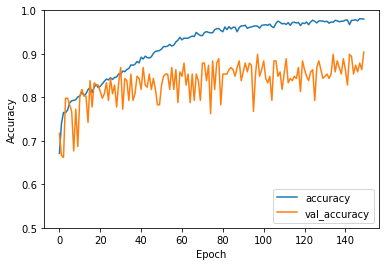

In [12]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [16]:
model.save_weights(
    'DenseNet_2.tf', overwrite=True
)